In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import time
import copy
from tqdm.notebook import tqdm
import pandas as pd

# Set device - for MacBook M3 Pro, use MPS
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    
print(f"Using device: {device}")


Using device: mps


In [9]:
# Data augmentation and normalization for training
# CIFAR-10 mean and std for normalization
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2470, 0.2435, 0.2616)

# Training transforms with data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

# Test transforms - only normalization
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

# Load CIFAR-10 dataset
batch_size = 128
num_workers = 2

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Get class names
classes = train_dataset.classes
print(f"Classes: {classes}")
print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")


Files already downloaded and verified
Files already downloaded and verified
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Training set size: 50000
Test set size: 10000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


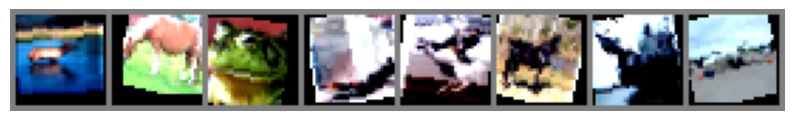

 deer horse  frog truck horse horse  ship airplane


In [10]:
# Visualize some training images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:8]))
# Print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))


In [11]:
def create_model(model_name='resnet18', num_classes=10, feature_extract=True, pretrained=True):
    """
    Create a model for transfer learning
    model_name: name of the model to use (e.g., 'resnet18', 'resnet50', 'vgg16')
    num_classes: number of classes in the dataset
    feature_extract: If True, only update the reshaped layer params
    pretrained: If True, use pre-trained weights
    """
    if model_name == 'resnet18':
        model = models.resnet18(weights='IMAGENET1K_V1' if pretrained else None)
    elif model_name == 'resnet34':
        model = models.resnet34(weights='IMAGENET1K_V1' if pretrained else None)
    elif model_name == 'resnet50':
        model = models.resnet50(weights='IMAGENET1K_V1' if pretrained else None)
    elif model_name == 'vgg16':
        model = models.vgg16(weights='IMAGENET1K_V1' if pretrained else None)
    else:
        raise ValueError(f"Model {model_name} not supported")
    
    # Set grad=False to freeze the parameters so the gradients are not computed in backward()
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False
    
    # Replace the last fully connected layer
    # Parameters of newly constructed modules have requires_grad=True by default
    if model_name.startswith('resnet'):
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )
    elif model_name.startswith('vgg'):
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )
    
    return model

# Create the model
model_name = 'resnet18'  # Options: 'resnet18', 'resnet34', 'resnet50', 'vgg16'
feature_extract = True  # Set to False to fine-tune the whole model
pretrained = True  # Set to False to train from scratch

model = create_model(model_name, num_classes=len(classes), feature_extract=feature_extract, pretrained=pretrained)
model = model.to(device)

# Print model summary (layer information)
print(f"Model: {model_name}")
print(f"Feature extraction mode: {feature_extract}")
print(f"Using pre-trained weights: {pretrained}")

# Count parameters
params_to_update = []
total_params = 0
trainable_params = 0

for name, param in model.named_parameters():
    total_params += param.numel()
    if param.requires_grad:
        trainable_params += param.numel()
        params_to_update.append(param)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params:.2%})")


Model: resnet18
Feature extraction mode: True
Using pre-trained weights: True
Total parameters: 11,444,298
Trainable parameters: 267,786 (2.34%)


In [12]:
# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.SGD(params_to_update, lr=0.01, momentum=0.9)

# Learning rate scheduler (reduce LR on plateau)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)

def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    """
    Train the model and return the best model weights
    """
    since = time.time()
    
    # Initialize tracking variables
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            loader = dataloaders[phase]
            pbar = tqdm(loader, total=len(loader))
            for inputs, labels in pbar:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                # Track history only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                # Update progress bar
                pbar.set_description(f'{phase} Loss: {loss.item():.4f}')
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            # Use float() instead of double() for MPS compatibility
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Store history for plotting - ensure values are moved to CPU for MPS compatibility
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.detach().cpu().item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.detach().cpu().item())
                # Learning rate scheduler step
                scheduler.step(epoch_loss)
            
            # Deep copy the model if it's the best accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    # Return model and history
    history = {
        'train_loss': train_loss_history,
        'val_loss': val_loss_history,
        'train_acc': train_acc_history,
        'val_acc': val_acc_history
    }
    
    return model, history

def test_model(model, dataloader, criterion):
    """
    Test the model on the test set
    """
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    
    all_preds = []
    all_labels = []
    
    # No gradient calculation needed
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, total=len(dataloader)):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            # Store predictions and labels for confusion matrix
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    test_loss = running_loss / len(dataloader.dataset)
    # Use float() instead of double() for MPS compatibility
    test_acc = running_corrects.float() / len(dataloader.dataset)
    
    print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')
    
    # Move tensor to CPU before returning for MPS compatibility
    test_acc_cpu = test_acc.detach().cpu().item()
    
    return test_loss, test_acc_cpu, all_preds, all_labels

# Prepare dataloaders dictionary
dataloaders = {
    'train': train_loader,
    'val': test_loader  # Using test set as validation
}


In [13]:
# Train the model
num_epochs = 10  # Increase for better performance
model_ft, history = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/10
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 1.8844 Acc: 0.3233


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 1.7832 Acc: 0.3631

Epoch 2/10
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 1.7749 Acc: 0.3630


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 1.7483 Acc: 0.3792

Epoch 3/10
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 1.7326 Acc: 0.3772


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 1.7275 Acc: 0.3842

Epoch 4/10
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 1.7209 Acc: 0.3825


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 1.6987 Acc: 0.3968

Epoch 5/10
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 1.7029 Acc: 0.3905


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 1.6872 Acc: 0.4023

Epoch 6/10
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 1.6908 Acc: 0.3932


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 1.6846 Acc: 0.4012

Epoch 7/10
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 1.6817 Acc: 0.3971


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 1.6613 Acc: 0.4061

Epoch 8/10
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 1.6744 Acc: 0.4017


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 1.6880 Acc: 0.3993

Epoch 9/10
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 1.6654 Acc: 0.3999


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 1.6841 Acc: 0.3989

Epoch 10/10
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 1.6632 Acc: 0.4033


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 1.6568 Acc: 0.4056

Training complete in 5m 6s
Best val Acc: 0.4061


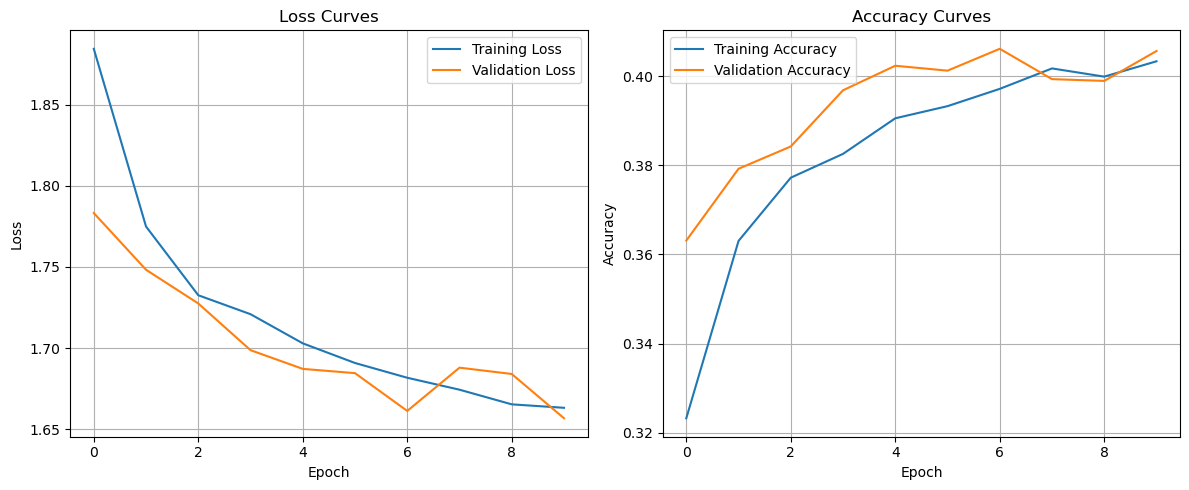

In [14]:
# Plot training and validation metrics
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 1.6613 Acc: 0.4061


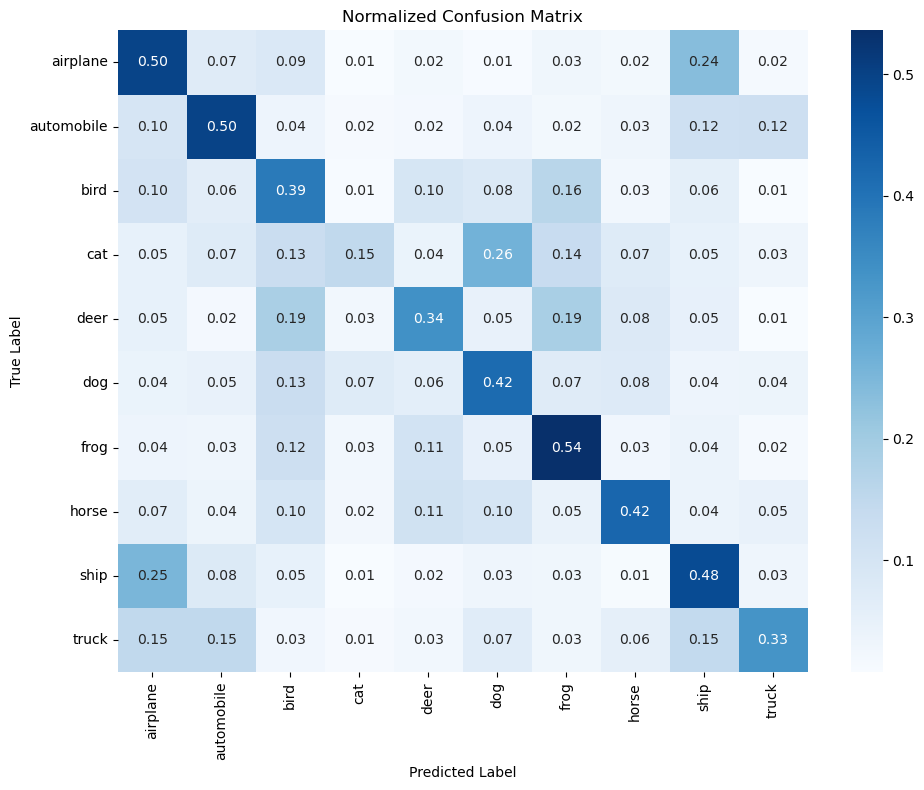

Per-class accuracy:
airplane: 0.4960
automobile: 0.4980
bird: 0.3870
cat: 0.1500
deer: 0.3390
dog: 0.4160
frog: 0.5360
horse: 0.4250
ship: 0.4820
truck: 0.3320

Overall Metrics:
Accuracy: 0.4061
Precision: 0.4156
Recall: 0.4061
F1 Score: 0.3994


In [15]:
# Test the model on the test set
test_loss, test_acc, all_preds, all_labels = test_model(model_ft, test_loader, criterion)

# Plot confusion matrix
import sklearn.metrics as metrics
import seaborn as sns

# Compute confusion matrix
cm = metrics.confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=classes, yticklabels=classes)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Normalized Confusion Matrix')
plt.tight_layout()
plt.show()

# Calculate per-class metrics
print("Per-class accuracy:")
for i, class_name in enumerate(classes):
    class_acc = cm[i, i] / cm[i].sum() if cm[i].sum() > 0 else 0
    print(f"{class_name}: {class_acc:.4f}")

# Calculate precision, recall, and F1 score
precision = metrics.precision_score(all_labels, all_preds, average='macro')
recall = metrics.recall_score(all_labels, all_preds, average='macro')
f1 = metrics.f1_score(all_labels, all_preds, average='macro')

print(f"\nOverall Metrics:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

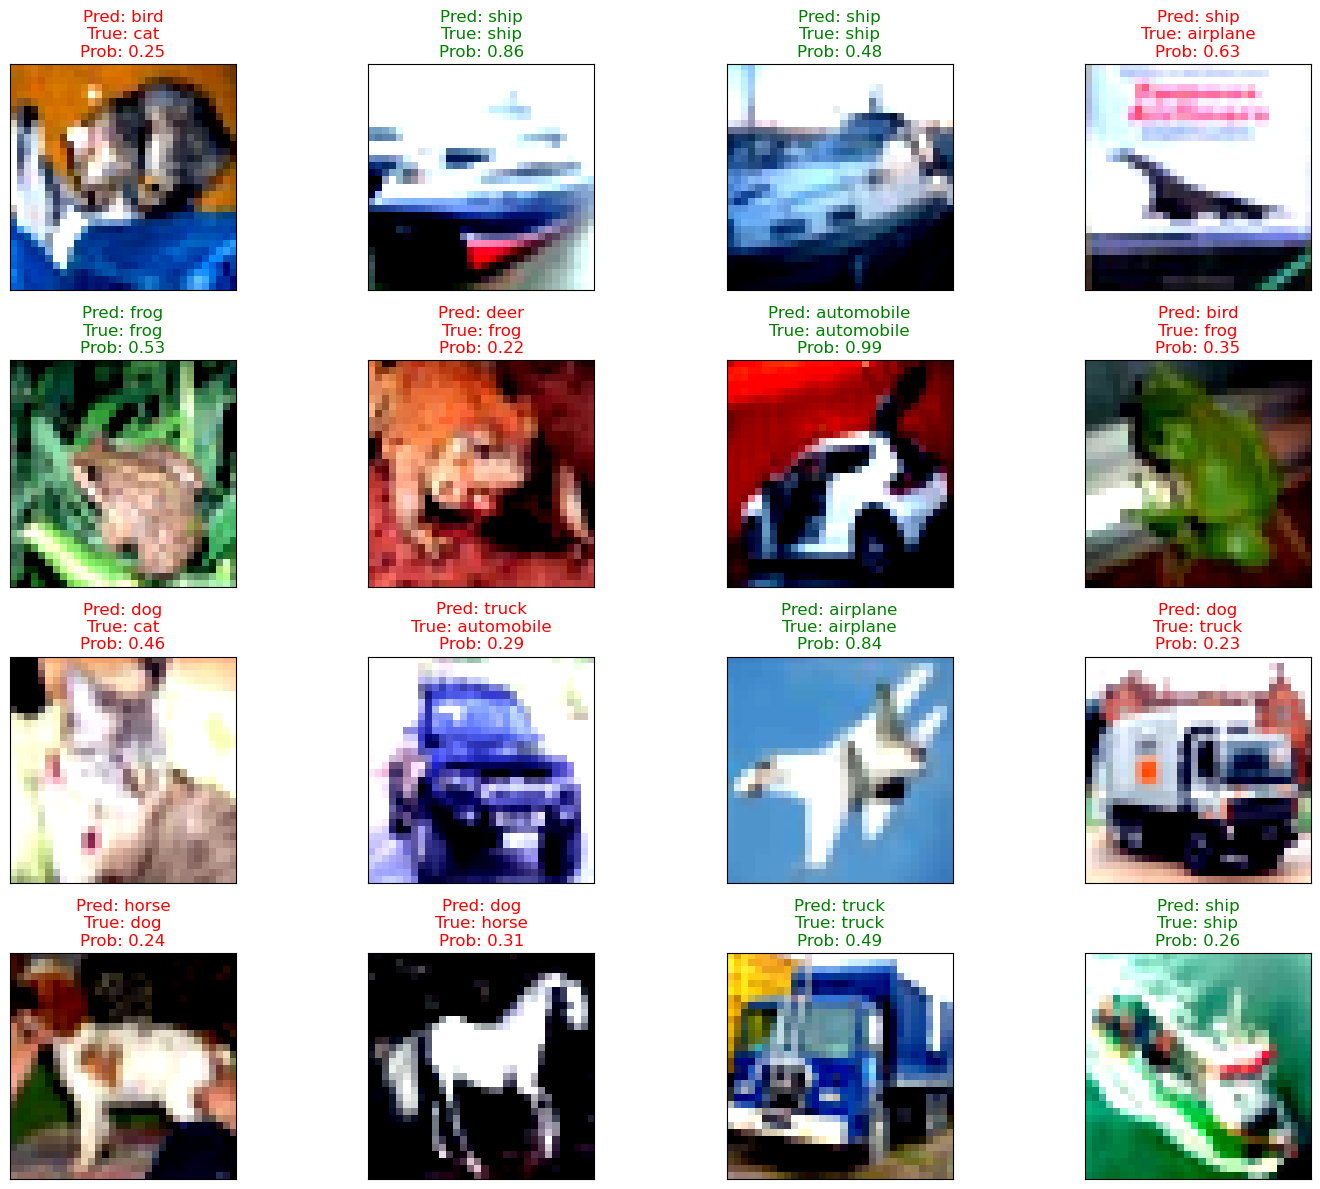

In [16]:
# Function to show images with predictions
def visualize_predictions(model, dataloader, num_images=16):
    # Get a batch of images
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    
    # Make predictions
    model.eval()
    with torch.no_grad():
        outputs = model(images.to(device))
        _, preds = torch.max(outputs, 1)
        probs = torch.nn.functional.softmax(outputs, dim=1)
    
    # Move tensors to CPU
    images = images.cpu()
    labels = labels.cpu()
    preds = preds.cpu()
    probs = probs.cpu()
    
    # Create a grid of images
    fig = plt.figure(figsize=(15, 12))
    
    # Plot at most num_images
    num_to_plot = min(num_images, images.size(0))
    for idx in range(num_to_plot):
        ax = fig.add_subplot(4, 4, idx+1, xticks=[], yticks=[])
        
        # Display the image
        img = images[idx] / 2 + 0.5  # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        
        # Get prediction information
        pred_class = classes[preds[idx]]
        true_class = classes[labels[idx]]
        prob = probs[idx, preds[idx]].item()
        
        # Set title color based on correct/incorrect prediction
        title_color = 'green' if preds[idx] == labels[idx] else 'red'
        
        # Add title with prediction and confidence
        ax.set_title(f"Pred: {pred_class}\nTrue: {true_class}\nProb: {prob:.2f}", 
                     color=title_color)
    
    plt.tight_layout()
    plt.show()

# Visualize some predictions
visualize_predictions(model_ft, test_loader)


In [17]:
# Function to train and evaluate a model
def train_and_evaluate(model_name, feature_extract, num_epochs=5):
    """
    Train and evaluate a model with the given configuration
    """
    print(f"Training {model_name} with feature_extract={feature_extract}")
    
    # Create model
    model = create_model(model_name, num_classes=len(classes), 
                         feature_extract=feature_extract, pretrained=True)
    model = model.to(device)
    
    # Define optimizer
    if feature_extract:
        params_to_update = [p for p in model.parameters() if p.requires_grad]
    else:
        params_to_update = model.parameters()
    
    # Use Adam optimizer for faster convergence
    optimizer = optim.Adam(params_to_update, lr=0.001)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 'min', patience=2, factor=0.5, verbose=True)
    
    # Train the model
    model, history = train_model(
        model, dataloaders, criterion, optimizer, scheduler, num_epochs=num_epochs)
    
    # Test the model
    test_loss, test_acc, _, _ = test_model(model, test_loader, criterion)
    
    return model, history, test_acc

# Dictionary to store results
results = {}


In [18]:
# Experiment 1: ResNet18 with feature extraction
model_resnet18_feat_ext, history_resnet18_feat_ext, acc_resnet18_feat_ext = train_and_evaluate(
    'resnet18', feature_extract=True, num_epochs=5)
results['resnet18_feat_ext'] = acc_resnet18_feat_ext


Training resnet18 with feature_extract=True
Epoch 1/5
----------


/Users/voldemort/anaconda3/envs/ece60146/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 1.8495 Acc: 0.3339


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 1.7980 Acc: 0.3587

Epoch 2/5
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 1.7548 Acc: 0.3698


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 1.7582 Acc: 0.3744

Epoch 3/5
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 1.7291 Acc: 0.3797


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 1.7712 Acc: 0.3768

Epoch 4/5
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 1.7101 Acc: 0.3842


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 1.7017 Acc: 0.3947

Epoch 5/5
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 1.7048 Acc: 0.3863


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 1.6937 Acc: 0.3922

Training complete in 2m 33s
Best val Acc: 0.3947


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 1.7017 Acc: 0.3947


In [19]:
# Experiment 2: ResNet18 with fine-tuning
model_resnet18_fine_tune, history_resnet18_fine_tune, acc_resnet18_fine_tune = train_and_evaluate(
    'resnet18', feature_extract=False, num_epochs=5)
results['resnet18_fine_tune'] = acc_resnet18_fine_tune


Training resnet18 with feature_extract=False
Epoch 1/5
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 1.1583 Acc: 0.6024


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 0.8836 Acc: 0.7082

Epoch 2/5
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 0.8865 Acc: 0.7010


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 0.7889 Acc: 0.7258

Epoch 3/5
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 0.8010 Acc: 0.7305


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 0.8176 Acc: 0.7280

Epoch 4/5
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 0.7447 Acc: 0.7484


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 0.6976 Acc: 0.7754

Epoch 5/5
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 0.7022 Acc: 0.7642


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 0.6102 Acc: 0.7896

Training complete in 3m 30s
Best val Acc: 0.7896


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.6102 Acc: 0.7896


In [20]:
# Experiment 3: ResNet50 with feature extraction
model_resnet50_feat_ext, history_resnet50_feat_ext, acc_resnet50_feat_ext = train_and_evaluate(
    'resnet50', feature_extract=True, num_epochs=5)
results['resnet50_feat_ext'] = acc_resnet50_feat_ext


Training resnet50 with feature_extract=True


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/voldemort/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 62.4MB/s]


Epoch 1/5
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 1.7932 Acc: 0.3587


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 1.7870 Acc: 0.3981

Epoch 2/5
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 1.6788 Acc: 0.3995


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 1.7039 Acc: 0.4106

Epoch 3/5
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 1.6388 Acc: 0.4118


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 1.7109 Acc: 0.4034

Epoch 4/5
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 1.6182 Acc: 0.4195


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 1.6834 Acc: 0.4177

Epoch 5/5
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 1.6095 Acc: 0.4255


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 1.6439 Acc: 0.4351

Training complete in 3m 37s
Best val Acc: 0.4351


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 1.6439 Acc: 0.4351


In [21]:
# Experiment 4: VGG16 with feature extraction
model_vgg16_feat_ext, history_vgg16_feat_ext, acc_vgg16_feat_ext = train_and_evaluate(
    'vgg16', feature_extract=True, num_epochs=5)
results['vgg16_feat_ext'] = acc_vgg16_feat_ext


Training vgg16 with feature_extract=True


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/voldemort/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:09<00:00, 60.2MB/s] 


Epoch 1/5
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 1.5880 Acc: 0.4296


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 1.2787 Acc: 0.5394

Epoch 2/5
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 1.5089 Acc: 0.4558


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 1.2651 Acc: 0.5428

Epoch 3/5
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 1.4902 Acc: 0.4624


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 1.2650 Acc: 0.5400

Epoch 4/5
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 1.4791 Acc: 0.4671


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 1.2581 Acc: 0.5478

Epoch 5/5
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 1.4768 Acc: 0.4711


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 1.2383 Acc: 0.5580

Training complete in 3m 16s
Best val Acc: 0.5580


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 1.2383 Acc: 0.5580
